In [ ]:
%%capture
!python3 -m venv venv
!source venv/bin/activate
!pip install tensorflow transformers

In [ ]:
import tensorflow as tf
from tensorflow.keras import activations, optimizers, losses
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
import pickle
import pandas as pd
import numpy as np
from numpy import std
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import LeaveOneOut,KFold
import os
from keras.layers import Activation, Concatenate, Conv1D, Dense, Dropout, Embedding   
from keras.layers import Flatten, Input, LSTM,  Permute
from keras import datasets, layers, models, regularizers
from transformers import DistilBertModel, TFDistilBertModel
import keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # suppress Tensorflow messages

In [ ]:
""" 
    PROCESS DATA FRAME

    ARGS:
        (string) file location

    Return:
      Pandas dataframe filled with text from comma separated values (.csv) file

      deleted id column
      created row with numerical representation of class value
        0 - not sarcastic
        1 - sarcastic
"""
def process_data(s):
  #'/content/drive/MyDrive/~MTSU/research/Corpus/GEN-sarc-notsarc.csv'
  dataframe = pd.read_csv(s,sep=',',dtype=str,na_values=0)
  del dataframe['id']
  dataframe['label'] = dataframe['class'].map({'notsarc':0,'sarc':1})
  dataframe = dataframe.dropna(how='any',axis=0)
  dataframe = shuffle(dataframe)  
  return dataframe

In [ ]:
log_dir='/content/drive/MyDrive/~MTSU/research/data/Bert/CNN_Model/'
model_save_path='/content/drive/MyDrive/~MTSU/research/data/Bert/CNN_Model/glove_model.h5'

In [ ]:
sarc_df = process_data('/content/drive/MyDrive/~MTSU/research/Corpus/GEN-sarc-notsarc.csv')

In [ ]:
sarc_df.head()

,class,text,label
2017,notsarc,I disagree for the same reasons I have been gi...,0
6214,sarc,I can understand your disappointment. Its very...,1
5218,notsarc,"Oh, probably about as many as there are killed...",0
539,notsarc,For years I've tried to get one of our residen...,0
1666,notsarc,But there were not always laws on the books th...,0


In [ ]:
''' 
    create list of X values from text column in dataframe
    create list of labels from created label column
'''
X = list(sarc_df['text'])
labels = list(sarc_df['label'])

In [ ]:
X[0:5]

['I disagree for the same reasons I have been giving all along. There may be some legislation that was passed that has kept corporations small (Anti-trust) but did it really benefit the society?',
 "I can understand your disappointment. Its very difficult to cure someone of chronic religious delusions. No easy way to relieve the suffering of the victim. But if you really work hard at it for another decade or so you may recover yet. Best of luck and don't fall for the quacks peddling quick cures.",
 'Oh, probably about as many as there are killed by bayonet lugs, pistol grips, heat shields, detachable magazines, and folding stocks.',
 "For years I've tried to get one of our resident gay members to debate me on that fact. To date, no takers. Want to step up?",
 'But there were not always laws on the books that prevented these things. I was presenting a hypothetical situation in which those laws are not already on the books. The situtation was intended to show only that a ruling allowing 

In [ ]:
'''
  model name from distilbert core model - vocab source

  max len
'''
MODEL_NAME = 'distilbert-base-uncased'
MAX_LEN = 200

'''
      demo of tokenization and its return

        phrase is first instance in X

        call tokenizer from vocab source

        output returned to inputs

              demo =>
                  access print statements
'''
phrase = X[0]

tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

inputs = tokenizer(phrase, max_length=MAX_LEN, truncation=True, padding=True)

print(f'Phrase: \'{phrase}\'')
print(f'input ids: {inputs["input_ids"]}')
print(f'attention mask: {inputs["attention_mask"]}')

Phrase: 'I disagree for the same reasons I have been giving all along. There may be some legislation that was passed that has kept corporations small (Anti-trust) but did it really benefit the society?'
input ids: [101, 1045, 21090, 2005, 1996, 2168, 4436, 1045, 2031, 2042, 3228, 2035, 2247, 1012, 2045, 2089, 2022, 2070, 6094, 2008, 2001, 2979, 2008, 2038, 2921, 11578, 2235, 1006, 3424, 1011, 3404, 1007, 2021, 2106, 2009, 2428, 5770, 1996, 2554, 1029, 102]
attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
def construct_encodings(x, tkzr, max_len, trucation=True, padding=True):
    """Pad each sentence to the maximum sentence length and encode tokens to
    their index in the vocabulary.

    Returns: Sequence of SEQUENCES
        input_ids 
        attention_masks 
    """
    return tkzr(x, max_length=max_len, truncation=trucation, padding=padding)
    

In [ ]:
encodings = construct_encodings(X, tokenizer, max_len=MAX_LEN)

In [ ]:
list(encodings)

['input_ids', 'attention_mask']

In [ ]:
dbert_model = TFDistilBertModel.from_pretrained(MODEL_NAME,trainable=False)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
class L_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=200,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(L_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.lstm_layer1 = LSTM(512,
                               activation='relu',
                               dropout=0.5, 
                               return_sequences=True,
                               kernel_regularizer=regularizers.l1(0.01))
        self.lstm_layer2 = LSTM(256, 
                               return_sequences=True)
        self.lstm_layer3 = LSTM(128, 
                               return_sequences=True)
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.lstm_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.lstm_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.lstm_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [1]:
"""
    PREDICTOR
  creates dataset from text passed,
  constructs tokenization
  compares predictions to existing labels
    return:
              prediction statistics

"""
def create_predictor(model, model_name, max_len, data ):
  tkzr = DistilBertTokenizer.from_pretrained(model_name)
  def predict_sarc(text):
      x = [text]

      encodings = construct_encodings(x, tkzr, max_len=max_len)
      preds = model.predict(encodings['input_ids'])
      preds = activations.softmax(tf.convert_to_tensor(preds)).numpy()
      return preds[0][0]
    
  return predict_sarc



In [ ]:
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 2

DROPOUT_RATE = 0.5

NB_EPOCHS = 3
k = 5
kf = KFold(n_splits=k, shuffle=False)

In [ ]:
from sklearn.model_selection import train_test_split,KFold , StratifiedKFold

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_accuracy',mode='max',save_best_only=False,save_freq=NB_EPOCHS),keras.callbacks.TensorBoard(log_dir=log_dir)]

In [ ]:
"""
  TRAIN MODEL 

    ARGS -
      x-train - input_ids training set
      x_valid - input_ids validation set
      y_train - label training set
      y_valid - label validation set
"""
def train_model(model, x_train,x_valid, y_train, y_val):
  if OUTPUT_CLASSES == 2:
    model.compile(loss="binary_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])
  else:
    model.compile(loss="sparse_categorical_crossentropy",
                       optimizer="adam",
                       metrics=["sparse_categorical_accuracy"])

  history = model.fit(x_train, y=y_train,
              epochs=NB_EPOCHS, validation_data=(x_valid,y_val),callbacks=callbacks)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.legend(['Training Loss','Validation Loss'])
  plt.xlabel('Epoch')
  plt.ylabel('CCE Loss')
  plt.show()
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.legend(['Training','Validation'])
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (P)')
  plt.show()

Epoch 1/3
163/163 [==============================] - 70s 395ms/step - loss: 13.3517 - accuracy: 0.6656 - val_loss: 1.0417 - val_accuracy: 0.7408
Epoch 2/3
163/163 [==============================] - 67s 410ms/step - loss: 0.9235 - accuracy: 0.8186 - val_loss: 1.0414 - val_accuracy: 0.7385
Epoch 3/3
163/163 [==============================] - 64s 391ms/step - loss: 0.7522 - accuracy: 0.9047 - val_loss: 1.1564 - val_accuracy: 0.7124


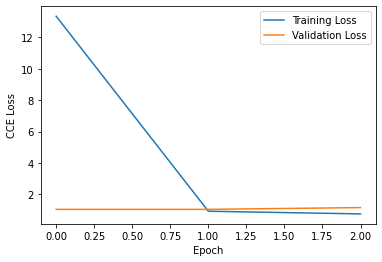

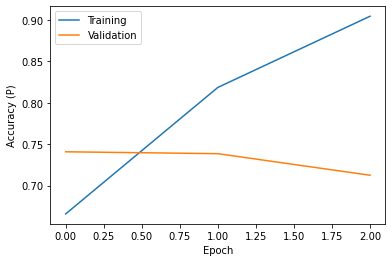

652/652 [==============================] - 38s 56ms/step - loss: 1.1564 - accuracy: 0.7124
{'loss': 1.1564351320266724, 'accuracy': 0.7124233245849609}


INFO:tensorflow:Assets written to: ram://f5ca678a-72d1-4a42-9371-a72d29cd4769/assets


INFO:tensorflow:Assets written to: ram://f5ca678a-72d1-4a42-9371-a72d29cd4769/assets


Epoch 1/3
163/163 [==============================] - 70s 401ms/step - loss: 13.3443 - accuracy: 0.6411 - val_loss: 1.0363 - val_accuracy: 0.7515
Epoch 2/3
163/163 [==============================] - 66s 401ms/step - loss: 0.9301 - accuracy: 0.8067 - val_loss: 1.0132 - val_accuracy: 0.7531
Epoch 3/3
163/163 [==============================] - 64s 392ms/step - loss: 0.7665 - accuracy: 0.8995 - val_loss: 1.1167 - val_accuracy: 0.7416


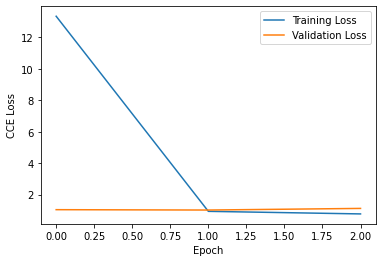

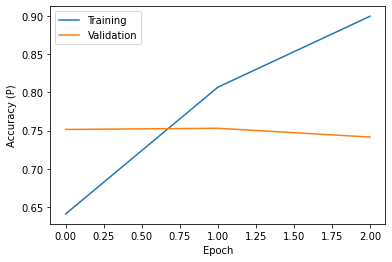

652/652 [==============================] - 38s 57ms/step - loss: 1.1167 - accuracy: 0.7416
{'loss': 1.1167064905166626, 'accuracy': 0.7415643930435181}


INFO:tensorflow:Assets written to: ram://598d3810-db2b-4f10-89bc-d02b3d9829c4/assets


INFO:tensorflow:Assets written to: ram://598d3810-db2b-4f10-89bc-d02b3d9829c4/assets


Epoch 1/3
163/163 [==============================] - 70s 406ms/step - loss: 13.3244 - accuracy: 0.6589 - val_loss: 1.0373 - val_accuracy: 0.7331
Epoch 2/3
163/163 [==============================] - 67s 408ms/step - loss: 0.9133 - accuracy: 0.8221 - val_loss: 1.0511 - val_accuracy: 0.7301
Epoch 3/3
163/163 [==============================] - 64s 393ms/step - loss: 0.7363 - accuracy: 0.9110 - val_loss: 1.1791 - val_accuracy: 0.7155


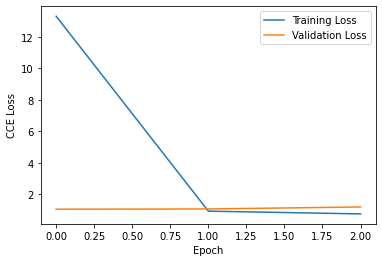

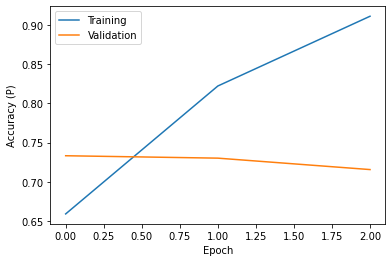

652/652 [==============================] - 38s 57ms/step - loss: 1.1791 - accuracy: 0.7155
{'loss': 1.1791220903396606, 'accuracy': 0.7154908180236816}


INFO:tensorflow:Assets written to: ram://f4babc13-4358-4403-9fd6-47377510bef7/assets


INFO:tensorflow:Assets written to: ram://f4babc13-4358-4403-9fd6-47377510bef7/assets


Epoch 1/3
163/163 [==============================] - 70s 405ms/step - loss: 13.3478 - accuracy: 0.6591 - val_loss: 1.0568 - val_accuracy: 0.7186
Epoch 2/3
163/163 [==============================] - 67s 411ms/step - loss: 0.9017 - accuracy: 0.8269 - val_loss: 1.0649 - val_accuracy: 0.7193
Epoch 3/3
163/163 [==============================] - 64s 395ms/step - loss: 0.7197 - accuracy: 0.9147 - val_loss: 1.2246 - val_accuracy: 0.7147


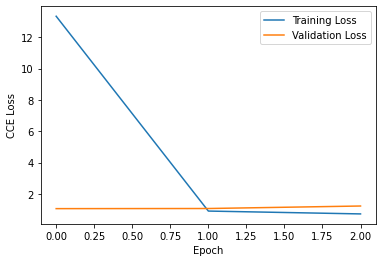

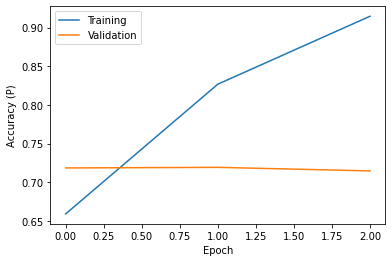

652/652 [==============================] - 38s 58ms/step - loss: 1.2246 - accuracy: 0.7147
{'loss': 1.2245525121688843, 'accuracy': 0.7147239446640015}


INFO:tensorflow:Assets written to: ram://254ba59f-07a7-420f-9806-fad56cc11161/assets


INFO:tensorflow:Assets written to: ram://254ba59f-07a7-420f-9806-fad56cc11161/assets


Epoch 1/3
163/163 [==============================] - 69s 403ms/step - loss: 13.4170 - accuracy: 0.6022 - val_loss: 1.1549 - val_accuracy: 0.6334
Epoch 2/3
163/163 [==============================] - 66s 405ms/step - loss: 1.0621 - accuracy: 0.7230 - val_loss: 1.0140 - val_accuracy: 0.7500
Epoch 3/3
163/163 [==============================] - 63s 389ms/step - loss: 0.8575 - accuracy: 0.8558 - val_loss: 1.0540 - val_accuracy: 0.7170


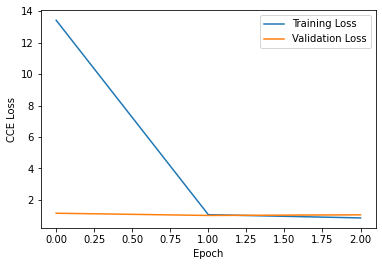

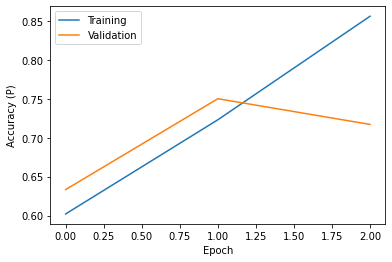

652/652 [==============================] - 39s 58ms/step - loss: 1.0540 - accuracy: 0.7170
{'loss': 1.0539958477020264, 'accuracy': 0.717024564743042}


INFO:tensorflow:Assets written to: ram://72d63347-55ef-4987-9398-6a29564e8a6a/assets


INFO:tensorflow:Assets written to: ram://72d63347-55ef-4987-9398-6a29564e8a6a/assets


In [ ]:
ids = np.asarray(encodings['input_ids'])
masks = np.array(encodings['attention_mask'])
labels = np.array(labels)
'''
    K FOLD VALIDATION LOOP

   X   create input_id training and validation sets in 
   Y   create label training and validation sets in
   M   create attention_mask training set in 

   model = none clears memory
   Create model

   Call train model function for learning

   benchmarks saves in evaluate and printed
   predictor made from model and compared to label set


   save model and weights in log_directory
'''
for train_index, val_index in kf.split(ids,masks,labels):
      #print("Training on fold " + str(index+1) + "/5..." )   # Generate batches from indices
      X_train, X_val = ids[train_index], ids[val_index]
      M_train, M_val = masks[train_index], masks[val_index]
      Y_train, Y_val = labels[train_index], labels[val_index]
     

      
      #print(Y_train[1:5], "\n    ", M_train[1:5], "\n    ", X_train[1:5])
      #print("Training new iteration on " + str(X_train.shape) + " training samples, " + str(X_val.shape) + " validation samples, this may be a while...")
      model = None
      model = L_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)
      history = train_model(model, X_train, X_val, Y_train, Y_val)
      benchmarks = model.evaluate(X_val,y=Y_val, return_dict=True, batch_size=BATCH_SIZE)
      print(benchmarks)
      clf = create_predictor(model, MODEL_NAME, MAX_LEN, (X_val,Y_val))
      dbert_model.save_pretrained(log_dir)
      with open(model_save_path, 'wb') as f:
          pickle.dump((model, MAX_LEN), f)

In [ ]:
preds = trained_model.predict([val_inp,val_mask],batch_size=16)
pred_labels = preds.argmax(axis=1)
f1 = f1_score(val_label,pred_labels)
f1

0.7216494845360826

In [ ]:
print('F1 score',f1)
print('Classification Report')
print(classification_report(val_label,pred_labels,target_names=target_names))

F1 score 0.7216494845360826
Classification Report
              precision    recall  f1-score   support

     notsarc       0.72      0.84      0.78       665
        sarc       0.80      0.66      0.72       639

    accuracy                           0.75      1304
   macro avg       0.76      0.75      0.75      1304
weighted avg       0.76      0.75      0.75      1304

